# 星形成領域「Dendrogramの利用」

恒星の誕生は、分子ガスなどの星間物質が集まった分子雲の中の、さらに高密度に集まった塊である分子雲コアで起こることが知られています。 
この分子雲コアを同定し、その物理情報（サイズ・速度線幅・質量等）を知る事は、星を形成する環境を理解する上で重要な情報になります。 
そこで、星形成領域の高密度分子雲の観測データをもとに、分子雲コアを同定する試みが様々な方法で行われてきています。
これまで同定アルゴリズムとして様々なものが提案されてきましたが、その一つにDendrogramアルゴリズムがあります。
ここでは、ALMAで観測されたデータをもとに、Dendrogramの使用例を紹介します。なお、この方法で検出した構造が分子雲コアとみなせるかどうかについては注意深い議論が必要となることに注意してください。
<br><br>
Dendrogramは、多次元のデータセットにおいて階層構造を樹形図（デンドログラム; dendrogram）として分類するアルゴリズムです。
それぞれの階層の構造は
<ul>
    <li>最も細分化された部分構造を持たない構造をリーフ（leaf）</li>
    <li>親構造から細分化さた中間構造をブランチ（branch）</li>
    <li>親構造を持たない最も上位の構造をトランク（trunk）</li>
</ul>
として同定されます(Rosolowsky et al. 2008)。<br>
ここでは最も小さい部分構造を持たないリーフ（leaf）の検出を考えます。
<br><br>

<img src="https://dendrograms.readthedocs.io/en/stable/_images/schematic_tree.png" alt="dendrogram schematic tree" width="330" border="0">
<img src="https://dendrograms.readthedocs.io/en/stable/_images/schematic_structure_2.png" alt="dendrogram schematic tree" width="280" border="0">
<br>

Dendrogramについてのより詳細な情報は“<a href="https://dendrograms.readthedocs.io/en/stable/" target="_blank" rel="noopener">Astronomical Dendrograms in Python</a>”をご覧ください。
以下で紹介するスクリプトでは、こちらで配布されているPythonモジュールを使用しています。

## サンプルイメージデータ：NGC6334

サンプルとして以下で使⽤するデータは、ALMAで観測された星形成領域“NGC6334”北東領域の分子雲における、高密度ガストレーサーH$^{13}$CO$^+$ J=1-0分子輝線によるモザイクキューブイメージです。<br>
ALMA Science Archiveより、以下を検索してください。
<ul>
   <li>Project code: 2018.1.00981.S</li>
   <li>Source Name: Northeast_Section_of_NGC6334</li>
</ul>

JVOのサイトからもイメージFITSを直接ダウンロードできます。<br>
- Dataset Information：
    https://jvo.nao.ac.jp/portal/alma/archive.do?action=dataset.info&datasetId=ALMA01461998 <br>
- FITS link：
    http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01461998_00_00_00

## 0. Dendrogramコード

このコードは、<font color="red">PPV(位置-速度)イメージキューブデータ</font>に対してdendrogramを適用するためのJupyter notebook形式で書かれたPythonスクリプトです（2Dイメージデータには適用できません）。
<a href="https://colab.research.google.com/notebooks/" target="_blank" rel="noopener">Google Colaboratory</a>上で実行することも可能です。
<br>
イメージFITSの取得から、dendrogramへ適用するためのデータの準備、dendrogramの実行、コアの候補の選択と各パラメーターの決定を行います。
デフォルトのdendrogramの基準に加えて、速度軸方向でのselectionを行っています。
<br>
スクリプト中に<font color="red">「(要確認)」のコメントがあるパラメータは、注意すべきパラメータや、データに応じて変更が必要なパラメータです</font>。 
サンプルイメージデータの場合は変更しなくても最後まで実行できますが、別のデータを使用しようとする場合などは修正変更を検討して下さい。
この様なパラメータについては各Sectionで説明していますので、確認しながらSection毎に実行する事を推奨します。

## 1. モジュール

必要なPythonモジュールの読み込みを行っています。<br>
最初にGoogle Colab環境か識別し、Google Colab環境で実行されている場合は「!pip install \*\*\*」でGoogle Colab環境では用意されていないモジュールをインストールしています。<br>
「improt \*\*\*」では、この解析で必要なモジュールを読み込んでいます。ローカル環境で実行する際は、これらのモジュールがあらかじめインストールされている必要があります。<br>
「%matplotlib inline」は、Google Colab中でmatplotlibで作成した図等を表示するためのコマンドです。<br>

In [21]:
# For Google Colab（Google Colab環境か識別）
import sys
print(type(sys.modules))
moduleList = sys.modules
ENV_COLAB = False

if 'google.colab' in moduleList:
    print("google_colab")
    ENV_COLAB = True
else:
    print("Not google_colab")

<class 'dict'>
google_colab


In [22]:
#####################################
# Install modules for Google Colab
#####################################

if ENV_COLAB:
    print("install additional python module.")
    !pip install astrodendro==0.1.0

#####################################
# Import modules
#####################################

import os
import os.path
import urllib.request
import math
import numpy as np
import matplotlib.pyplot as plt
from astrodendro import Dendrogram
from astrodendro import ppv_catalog # for 3D image
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import time
import datetime
import csv

### for Google Colab
if ENV_COLAB:
    %matplotlib inline
    from google.colab import files

print("END: Section.1")

install additional python module.
END: Section.1


## 2. イメージFITSファイルをダウンロード

冒頭で紹介したサンプルデータをJVOからダウンロードします。
<ul>
  <li>url='http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01461998_00_00_00'</li>
  <li>imgfits='ALMA01461998_00_00_00.fits'</li>
</ul>
ここで、ダウンロードリンクのURLとダウンロードされるFITSの名前を指定しています。
JVOから別のアーカイブデータをダウンロードして使用する場合は、データに応じて修正して下さい。<br>
イメージFITSファイルが既に存在する時はスキップします。

In [23]:
url='http://jvo.nao.ac.jp/skynode/do/download/alma/public/cube_primary/ALMA01461998_00_00_00' # (要確認)
imgfits='ALMA01461998_00_00_00.fits' # (要確認)

if not (os.path.isfile(imgfits)):
    print(f"downloading fits file.: {imgfits}")
    urllib.request.urlretrieve(url, imgfits)
    print(f"finish download.")
else:
    print('fits file already exist.')

print("END: Section.2")

downloading fits file.: ALMA01461998_00_00_00.fits
finish download.
END: Section.2


イメージFITSファイルがあるかをチェック。「!+linuxコマンド」で、通常のlinuxコマンドが使用できます。

In [24]:
!ls -lh ALMA01461998*

-rw-r--r-- 1 root root 337M Jan  5 02:23 ALMA01461998_00_00_00.fits


## 3. FITSファイルの読み込み

ダウンロードしたイメージFITSのピクセルサイズ（特に3軸目の周波数方向）を確認。

In [25]:
ftdata = fits.open(imgfits)
ft_hdr = ftdata[0].header
ftdata.close()
print(ftdata.info())
print("")
print('NAXIS3: ', ft_hdr["NAXIS3"], 'pix')

Filename: ALMA01461998_00_00_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   (270, 320, 1021, 1)   float32   
None

NAXIS3:  1021 pix


ALMAアーカイブデータのイメージFITSは4軸目にStokes軸が定義されていますが、dendrogramはこれを扱えないためヘッダーの4軸目を削除したFITSを作り直します（偏波観測データでなければStokes軸はtotal intensity (Stokes I)しか実データがないので無視できる）。
また、処理時間短縮の目的でFITSデータサイズを削減するために、検出されるラインの両側のemissionがない周波数チャンネルを削除し、3軸目(周波数軸)を定義しなおしています。
<br><br>
以下は、以降で扱う修正されたFITSファイルの基本名です。必要に応じて修正して下さい。
<ul>
  <li>data_name='ngc6334.cube.image'</li>
</ul>
周波数軸について以下のチャンネル範囲のみを切り出します。必要に応じて修正して下さい。
<ul>
  <li>start_fch = 350 # ch</li>
  <li>end_fch   = 700 # ch</li>
</ul>
ラインの検出されない（emission free）周波数チャンネルを、後でノイズ（RMS）の大きさを求めるのに使います。このノイズの大きさを評価するために、十分なemission freeな周波数チャンネルが必要になりますので、目的のラインの両側にある程度ラインのないチャンネルが残る様に指定して下さい。
また、後でコアの候補として同定された成分の平均スペクトルに対してガウシアンフィットを行っています。このためにもラインの両側にemission freeな周波数領域が必要になります。
<br>
もし、新しいデータに適用する場合は、まずは
<ul>
  <li>start_fch = 0 # ch</li>
  <li>end_fch   = ft_hdr["NAXIS3"]-1 # ch</li>
</ul>
という様に全チャンネル（“ft_hdr["NAXIS3"]” は周波数方向の3軸目の総データ点数）を指定してSection 4.「平均スペクトルの作成」まで実行し、表示される平均スペクトルから切り出すべき周波数チャンネルを判断するのが良いでしょう。
<br><br>
この後で周波数を視線速度に変換するのに分子輝線の静止周波数の情報が必要になります。
ここでヘッダーに静止周波数があるか確認しています。
もしない場合、また期待する分子輝線の静止周波数と異なる場合は、“rtfreq”のコメントアウトを外して値を直接書き込んで下さい（単位はHz）。

In [26]:
data_name='ngc6334.cube.image' # (要確認)

## 一部の周波数チャンネルを切り出す場合：
start_fch = 350 # ch (要確認)
end_fch   = 700 # ch (要確認)

## 全周波数チャンネルを使用する場合：
#start_fch = 0 # ch (要確認)
#end_fch   = ft_hdr["NAXIS3"]-1 # ch (要確認)

rm_hdr=['NAXIS4','CTYPE4','CRVAL4','CDELT4','CRPIX4','CUNIT4','CUNIT4','CROTA4',
        'PC1_4','PC2_4','PC3_4','PC4_1','PC4_2','PC4_3','PC4_4']    

ftdatog = fits.open(imgfits)
ft_datog = ftdatog[0].data
ft_hdrog = ftdatog[0].header
ftdatog.close()
print(ftdatog.info())

for i in range(len(rm_hdr)):
    if rm_hdr[i] in ft_hdrog:
        ft_hdrog.remove(rm_hdr[i])
ft_hdrog['NAXIS'] = 3

print('')
print('NAXIS3: ', ft_hdrog["NAXIS3"])
print('CRVAL3: ', ft_hdrog["CRVAL3"])
print('CRPIX3: ', ft_hdrog["CRPIX3"])

print('')
# Checking Rest Frequency of target line
if 'RESTFRQ' in ft_hdrog:
    rtfreq = ft_hdrog["RESTFRQ"] # Hz
    print('Rest Frequency '+str(rtfreq/10**9)+' GHz for target line is correct ?')
else:
    print('Please set Rest Frequency due to no information !')
# Headerに"期待する"静止周波数情報がない場合は以下のコメントアウトを外して値を記述
#rtfreq = 8.6754288E+10 # Hz for H13CO+ J=1-0

rcrpix3 = int((start_fch+end_fch)/2)
ncrval3 = ft_hdrog["CRVAL3"] + (rcrpix3 - ft_hdrog["CRPIX3"]) * ft_hdrog["CDELT3"]
nnaxis3 = end_fch - start_fch +1
ncrpix3 = rcrpix3 - start_fch +1

ft_hdrog["NAXIS3"] = nnaxis3
ft_hdrog["CRVAL3"] = ncrval3
ft_hdrog["CRPIX3"] = ncrpix3
ft_hdrog["RESTFRQ"] = rtfreq

fits_name = data_name+'.fits'
if(os.path.isfile(fits_name) == True):
    os.remove(fits_name)
fits.writeto(fits_name, ft_datog[0,start_fch:end_fch+1,:,:], ft_hdrog, 
             overwrite=True)
print('')

ftdata = fits.open(fits_name)
ft_dat = ftdata[0].data
ft_hdr = ftdata[0].header
ftdata.close()
print(ftdata.info())

print('')
print('NAXIS3: ', ft_hdr["NAXIS3"])
print('CRVAL3: ', ft_hdr["CRVAL3"])
print('CRPIX3: ', ft_hdr["CRPIX3"])
print('RESTFRQ: ', ft_hdr["RESTFRQ"])

Filename: ALMA01461998_00_00_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   (270, 320, 1021, 1)   float32   
None

NAXIS3:  1021
CRVAL3:  86724181503.0
CRPIX3:  1.0

Rest Frequency 86.754288 GHz for target line is correct ?

Filename: ngc6334.cube.image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (270, 320, 351)   float32   
None

NAXIS3:  351
CRVAL3:  86756190436.51172
CRPIX3:  176
RESTFRQ:  86754288000.0


dendrogramの処理において、空間サイズの閾値として空間分解能の情報が必要になります。ALMAアーカイブ（JVO含む）からダウンロードしたFITSデータの場合はヘッダーに合成ビームサイズの情報をあるのでこれを読み出すようになっていますが、ヘッダーにビームサイズの情報(bmin, bmax)が無い場合や、別途実効空間分解能を指定したい場合は、直接書き込む必要があります。<br>
また、ここで3軸目の周波数を視線速度に置き換えています（ここで分子輝線の静止周波数情報が必要）。

In [27]:
fits_name = data_name+'.fits'
hdu  = fits.open(fits_name)[0]
data = hdu.data
hd   = hdu.header

# Header
wcs    = WCS(hdu.header)
naxis  = hdu.header["NAXIS"]
naxis1 = hdu.header["NAXIS1"]
naxis2 = hdu.header["NAXIS2"]
cdelt1 = hdu.header["CDELT1"]
cdelt2 = hdu.header["CDELT2"]
naxis3 = hdu.header["NAXIS3"]
crval3 = hdu.header["CRVAL3"]
crpix3 = hdu.header["CRPIX3"]
cdelt3 = hdu.header["CDELT3"]
# Effective Spatial Resolution (Headerにビームサイズ情報がない場合は値を記述)
bmin   = hdu.header["BMIN"] # deg
bmax   = hdu.header["BMAJ"] # deg

print("#######################")
print("## Check basic header info. ##")
print("#######################")
print("No. of pixel for each axis: ",naxis1," x ",naxis2," x ",naxis3)
print(f'Pixel size: {abs(cdelt1)*3600.:.7f} arcsec X {abs(cdelt2)*3600.:.7f} arcsec')
print(f'Bmin: {bmin*3600:.7f} arcsec')
print(f'Bmax: {bmax*3600:.7f} arcsec')
print("")

ccc = 2.998*10**(8)   # m/s   speed of light
print(f'rest freq.: {rtfreq/10**9:.7f} GHz')
print(f'crval3: {crval3/10**9:.7f} GHz')
print(f'cdelt3: {cdelt3:.7f} {hdu.header["CUNIT3"]:s}')
print("=>")
crval3 = (rtfreq-crval3)/rtfreq*ccc
cdelt3 = -cdelt3/rtfreq*ccc
print(f'crval3: {crval3/10**3:.7f} km/s')
print(f'cdelt3: {cdelt3/10**3:.7f} km/s')
hdu.header["CTYPE3"] = 'VELO'
hdu.header["CUNIT3"] = 'm/s'
hdu.header["CRVAL3"] = crval3
hdu.header["CDELT3"] = cdelt3

# 速度軸の定義
axis = np.array([i for i in range(naxis3)])
axis = crval3 + (axis - crpix3 + 1) * cdelt3
axis = axis/1000. # m/s to km/s

print("END: Section.3")

#######################
## Check basic header info. ##
#######################
No. of pixel for each axis:  270  x  320  x  351
Pixel size: 2.2000000 arcsec X 2.2000000 arcsec
Bmin: 11.0598693 arcsec
Bmax: 18.4876089 arcsec

rest freq.: 86.7542880 GHz
crval3: 86.7561904 GHz
cdelt3: 61085.7509766 Hz
=>
crval3: -6.5743202 km/s
cdelt3: -0.2110963 km/s
END: Section.3


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


## 4. 平均スペクトルの作成

イメージ領域全域で平均したスペクトルを表示します。

count_pixel : 50766.0 50772.0


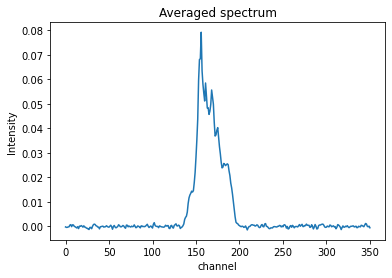

This section took  37.324660539627075  sec.
END: Section.4


In [28]:
start_time = time.time() 

#####################################
# Average Spectrum
#####################################
spectrum    = np.zeros(naxis3)
count_pixel = np.zeros(naxis3)

min_value = np.nanmin(data)  
max_value = np.nanmax(data)

for i in range(naxis1):
    for j in range(naxis2):
        for k in range(naxis3):
            pixel_value = data[k,j,i]
            if pixel_value >= min_value and pixel_value <= max_value:
                spectrum[k] = spectrum[k] + pixel_value
                count_pixel[k] = count_pixel[k] + 1

spectrum = spectrum/count_pixel
print('count_pixel :', np.min(count_pixel), np.max(count_pixel))

plt.figure()
plt.title("Averaged spectrum")
plt.plot(spectrum)
plt.xlabel("channel")
plt.ylabel("Intensity")
plt.show()

end_time = time.time() 
elapsed_time = end_time - start_time
print("This section took ", elapsed_time, " sec.")
print("END: Section.4")

## 5. SNマップ & RMSマップの作成

ノイズ（RMS）を見積もりたい速度チャンネルレンジを指定します。
採用するチャンネル数が出来るだけ多い方が典型的なRMSを適切に見積もれます。
一方、バンド端(数ch~10ch)はスプリアスがある場合があるので避けた方が良いです。
平均スペクトルでは弱いemissionは見えない場合があるので、emission周辺のチャンネルはさけた方が良いでしょう。<br>
emission freeのチャンネルについて、以下の4カ所をSection.4の平均スペクトルの結果などを参考に指定して下さい。
<ul>
  <li>start_x1 =  10 # ch</li>
  <li>end_x1   = 150 # ch</li>
  <li>start_x2 = 300 # ch</li>
  <li>end_x2   = 350 # ch</li>
</ul>
指定されたチャンネル範囲で測定されたRMSをもとに、RMSマップが作成されます。
さらに元のキューブデータとRMSマップから、SNマップも作成されます。<br>
平均スペクトルに指定されたemission freeチャンネルが書き込まれたプロット、RMSのヒストグラム、RMSマップが表示されます。

### スペクトル中の赤線はemission freeとして選択した範囲を表す ###


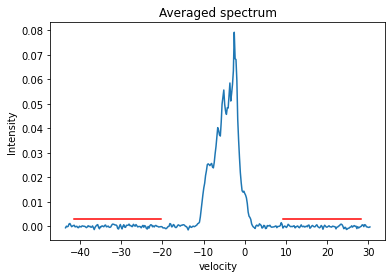

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: All-NaN slice encountered


Filename: ngc6334.cube.image.rms.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   (270, 320)   float64   
None


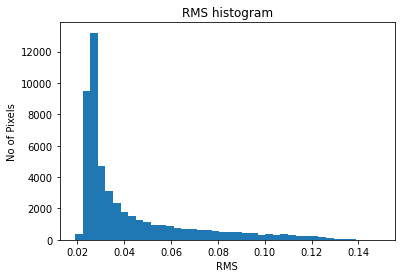

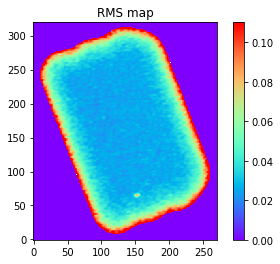

Filename: ngc6334.cube.image.SN.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (270, 320, 351)   float64   
None
END: Section.5


In [29]:
# 前節の平均スペクトルからemission freeチャンネルの範囲を指定
start_x1 =  10 # ch (要確認)
end_x1   = 100 # ch (要確認)
start_x2 = 240 # ch (要確認)
end_x2   = 340 # ch (要確認)

blrng = np.array([start_x1,end_x1,start_x2,end_x2])
blrng = crval3 + (blrng - crpix3 + 1) * cdelt3
blrng = blrng/1000.  # m/s to km/s

print("### スペクトル中の赤線はemission freeとして選択した範囲を表す ###")
baseline=np.nanmax(spectrum)*0.04
plt.figure()
plt.title("Averaged spectrum")
plt.plot(axis, spectrum)
plt.xlabel("velocity")
plt.ylabel("Intensity")
plt.plot([blrng[0],blrng[1]],[baseline,baseline],"r-")
plt.plot([blrng[2],blrng[3]],[baseline,baseline],"r-")
plt.show()

x1_ch = end_x1 - start_x1 + 1
x2_ch = end_x2 - start_x2 + 1

spectrum_tmp= np.zeros(naxis3)

min_value = np.nanmin(data)
max_value = np.nanmax(data)

#####################################
# making RMS map (2d)
#####################################
rms_tmp = np.zeros(x1_ch+x2_ch)
rms_map = np.zeros([naxis2,naxis1])
for j in range(naxis2):
    for i in range(naxis1):
        for k in range(naxis3):
            spectrum_tmp[k] = data[k,j,i]
        peak = np.nanmax(spectrum_tmp)
        if peak >= min_value and peak <= max_value:
            k_count = 0
            for kk in range(x1_ch):
                rms_tmp[k_count] = data[start_x1+kk,j,i]
                k_count = k_count+1
            for kkk in range(x2_ch):
                rms_tmp[k_count] = data[start_x2+kkk,j,i]
                k_count = k_count+1
            rms_map[j,i] = np.std(rms_tmp)

remove_candidate=['NAXIS3','CTYPE3','CRVAL3','CDELT3','CRPIX3','CUNIT3','CUNIT3','CROTA3',
                  'PC1_3','PC2_3','PC3_1','PC3_2','PC3_3',]

data_rms = fits.open(fits_name)[0]
for i in range(len(remove_candidate)):
    if remove_candidate[i] in data_rms.header:
        data_rms.header.remove(remove_candidate[i])

fits_name_rms = data_name+'.rms.fits'
if(os.path.isfile(fits_name_rms) == True):
    os.remove(fits_name_rms)
fits.writeto(fits_name_rms, rms_map, data_rms.header, overwrite=True)
print(fits.open(fits_name_rms).info())

nozmin = np.nanmin(rms_map[np.nonzero(rms_map)])
hi = np.reshape(rms_map, -1)
plt.figure()
plt.title("RMS histogram")
plt.hist(hi, bins=40, range=(nozmin, np.nanmax(rms_map)))
plt.xlabel("RMS")
plt.ylabel("No of Pixels")
plt.show()

vmaxrms = 0.11 # max level for RMS map image plot (注意)
#vmaxrms = np.nanmax(rms_map)
plt.figure()
plt.title("RMS map")
plt.imshow(rms_map, origin='lower', interpolation='nearest', cmap=plt.cm.rainbow, 
           vmin=np.nanmin(rms_map), vmax=vmaxrms)      
plt.colorbar()
plt.show()

#####################################
# making SN map (3d)
#####################################
SN_map = data/rms_map

for j in range(naxis2):
    for i in range(naxis1):
        if rms_map[j,i] <= 0.0001: # (注意)
            for k in range(naxis3):
                SN_map[k,j,i] = np.nan
        else:
            for k in range(naxis3):
                SN_map[k,j,i] = data[k,j,i]/rms_map[j,i]

data_SN = fits.open(fits_name)[0]
fits_name_SN = data_name+'.SN.fits'
if(os.path.isfile(fits_name_SN) == True):
    os.remove(fits_name_SN)
fits.writeto(fits_name_SN, SN_map, data_SN.header, overwrite=True)
print(fits.open(fits_name_SN).info())

print("END: Section.5")

## 6. モーメント0マップの作成

ここでは簡易的に全channelを積分してmoment 0マップ（積分強度図）を作成しています。<br>
マップを表示する際のカラーレンジは“intmin”, “intmax”で指定されます。手動で調整したい場合はJy/beam単位で値を指定する事が出来ます。

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 260.235251017  -35.72481978902  
CRPIX : 136.0  161.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0006111111120044  0.0006111111120044  
NAXIS : 270  320

Filename: ngc6334.cube.image.mom0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      66   (270, 320)   float32   


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


None


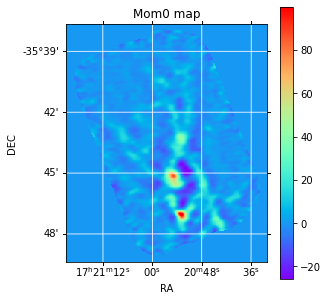

END: Section.6


In [30]:
#####################################
# making moment 0 map
#####################################
data_mom0 = fits.open(fits_name)[0]

# make mom0 map along axis=0(velocity)
mom0 = np.nansum(data_mom0.data, axis=0) 

# remove header for 3rd dimention
if data_mom0.header['NAXIS'] != 2:
    data_mom0.header['NAXIS']=2

remove_candidate=['NAXIS3','CTYPE3','CRVAL3','CDELT3','CRPIX3','CUNIT3','CUNIT3','CROTA3',
                  'PC1_3','PC2_3','PC3_1','PC3_2','PC3_3',]

for i in range(len(remove_candidate)):
    if remove_candidate[i] in data_mom0.header:
        data_mom0.header.remove(remove_candidate[i])

wcs = WCS(data_mom0.header)
print(wcs)

print("")
fits_name_mom0 = data_name+'.mom0.fits'
if(os.path.isfile(fits_name_mom0) == True):
    os.remove(fits_name_mom0)
fits.writeto(fits_name_mom0, mom0, data_mom0.header, overwrite=True)
print(fits.open(fits_name_mom0).info())

# color range of plotted mom0 image
intmin = np.nanmin(mom0)*0.9 if np.nanmin(mom0) < 0 else np.nanmin(mom0)*1.1
intmax = np.nanmax(mom0)*0.9
# plot mom0 map
plt.figure(figsize=(4.5,5))
plt.subplot(projection=wcs)
plt.imshow(mom0, vmin=intmin, vmax=intmax, 
           origin='lower', interpolation='nearest', cmap=plt.cm.rainbow)
plt.grid(color='white', ls='solid')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title("Mom0 map")
clb = plt.colorbar()
plt.show()

print("END: Section.6")

## 7. dendrogram

### 7-1. dendrogramの実行

以下のパラメータについて、dendrogramをSNマップにかけたい場合は「Yes」を、通常マップにかけたい場合は「No」を選択してください。
<ul>
  <li>option_for_appying_to_SNmap = "Yes" # dendrogramをSN mapにかけたいなら"Yes"</li>
  <li>option_for_appying_to_SNmap = "No" # dendrogramを通常mapにかけたいなら"No"</li>
</ul>
dendrogramのパラメータとして以下を指定します。
<ul>
  <li>sigma      = 1. </li>
</ul>
通常マップにかける場合に使用され、1$\sigma$ノイズレベルの値を入力して下さい。SNマップにかける場合は、後で"1.0"に強制的に置き換えられます。
<ul>
  <li>peak_value > 80.0*sigma</li>
</ul>
ピークのpixel値の閾値で、ここで指定したSN以下のピークは除外されます。必要に応じて変更して下さい。コア状とは言えない様な細切れな構造が大量に検出される場合は、調整が必要かもしれません。
<ul>
  <li>min_value_threshold = 40.0 # sigma</li>
  <li>min_delta_threshold = 40.0 # sigma</li>
  <li>min_npix_threshold  = 1.</li>
</ul>
“min_value”, “min_delta”, “min_npix”は、dendrogramが構造を同定する時のパラメータです。
これらのパラメータについてのより詳細な情報は
<a href="https://dendrograms.readthedocs.io/en/stable/using.html" target="_blank" rel="noopener">dendrogram</a>
のホームページをご覧ください。
<br><br>
<font color="red">現在はデモ版として処理時間を短くするために、“peak_value”, “min_value_threshold”, “min_delta_threshold”には高い値を設定しています。実際に研究に使う際は、先行研究で使われているパラメータを参照するなどしてより小さい値に調整して下さい。</font><br>
一方、ビームサイズより小さな構造はリアルとは言えないので、“min_npix”は少なくてもppb以上であるべきです（なお“min_npix_threshold”はppbの何倍かで定義されています）。

In [31]:
option_for_appying_to_SNmap = "Yes" # dendrogramをSN mapにかけたいなら"Yes"
#option_for_appying_to_SNmap = "No" # dendrogramを通常mapにかけたいなら"No"

sigma      = 1. # (要確認) 1 sigma noisel levelの値を入力
ppb        = 1.0*bmin/2.*bmax/2.*math.pi/abs(cdelt1)/abs(cdelt1) #
pixel_size = abs(cdelt1)*3600.
print("ppb=",ppb)  # 1 beamに対応するピクセル数

# select cores with peak value over N sigma (additional criteria)
def custom_independent(structure,index=None,value=None):
    peak_index,peak_value=structure.get_peak()
    return peak_value > 80.0*sigma   # (要確認)
#    return peak_value > 40.0*sigma   # (要確認)

# definition of dendrogram parameters
min_value_threshold = 40.0 # sigma (要確認) 
min_delta_threshold = 40.0 # sigma (要確認)
#min_value_threshold = 20.0 # sigma (要確認) 
#min_delta_threshold = 20.0 # sigma (要確認)
min_npix_threshold  = 1. # (要確認) beam size相当のpixel数の何倍以上までかの閾値

# 通常のcube mapにapplyする場合
if option_for_appying_to_SNmap == str("No"):
    print("==> Dendrogram is applying to cube map.") 
    d = Dendrogram.compute(data, min_value=min_value_threshold*sigma, 
                           min_delta=min_delta_threshold*sigma, 
                           min_npix=min_npix_threshold*ppb,
                           is_independent=custom_independent)

# SN mapにapplyする場合
if option_for_appying_to_SNmap == str("Yes"):
    print("==> Dendrogram is applying to SN map.")
    sigma = 1.0
    d = Dendrogram.compute(SN_map, min_value=min_value_threshold*sigma, 
                           min_delta=min_delta_threshold*sigma, 
                           min_npix=min_npix_threshold*ppb,
                           is_independent=custom_independent)

print("END: Section.7-1")

ppb= 33.179914111199906
==> Dendrogram is applying to SN map.
END: Section.7-1


### 7-2. 結果のFITSへの出力とFITSのダウンロード

dendrogramの結果をFITSファイルに出力します。さらに、dendrogramにより出力されたFITSは2つのextentionを持ちますが、このままでは扱いに困るのでこれを別々のFITSに分割して出力します。<br>
1つ目のextentionは、オリジナルのFITSをregridしたもので、基本的には入力したFITSと同じです。２つ目のextentionと比較する際に便利です。<br>
2つ目のextentionは、dendrogramで同定された構造のID番号をマップ上に示した物で、各pixelの値が所属する構造のID番号に対応しています。<br>
以下で、作成されるFITSの名前を指定出来ます。
<ul>
  <li>output_name     ="ngc6334.dendrogram_result.fits"</li>
  <li>output_name_ext1="ngc6334.dendrogram_result_ext1_map.fits"</li>
  <li>output_name_ext2="ngc6334.dendrogram_result_ext2_id_number.fits"</li>
</ul>
Google Colabで実行する場合、download_files = "yes"とすると出力されたFITSをローカル環境にダウンロードします。

In [32]:
#download_files = "yes"
download_files = "no"

output_name     ="ngc6334.dendrogram_result.fits"                # (要確認)
output_name_ext1="ngc6334.dendrogram_result_ext1_map.fits"       # (要確認)
output_name_ext2="ngc6334.dendrogram_result_ext2_id_number.fits" # (要確認)

if(os.path.isfile(output_name) == True): os.remove(output_name)
if(os.path.isfile(output_name_ext1) == True): os.remove(output_name_ext1)
if(os.path.isfile(output_name_ext2) == True): os.remove(output_name_ext2)

# output FITS files of dendrogram result & donwload the FITS (if necessary)
d.save_to(output_name) # transfer FITS from dendrogram result
if download_files =="yes":
    files.download(output_name) # donwload the FITS (for Google Colab)
    print("Downloaded", output_name)

# separate "1st" extention from dendrogram FITS & output other FITS
ext1 = fits.open(output_name)[1]
ext1.writeto(output_name_ext1)
if download_files =="yes":
    files.download(output_name_ext1)
    print("Downloaded", output_name_ext1)

# separate "2nd" extention from dendrogram FITS & output other FITS
ext2 = fits.open(output_name)[2]
ext2.writeto(output_name_ext2)
if download_files =="yes":
    files.download(output_name_ext2)
    print("Downloaded", output_name_ext2)

print("END: Section.7-2")

END: Section.7-2


### 7-3. テーブルを作成するための準備

data_unit（強度単位）については、ALMAデータの場合は通常Jy/beamですのでそのまま「u.Jy/u.beam」を使用し、それ以外の場合（例えばKの場合）は便宜的に「u.Jy」を指定して下さい。

In [33]:
metadata = {}
#metadata['data_unit'] = u.Jy
metadata['data_unit'] = u.Jy / u.beam
metadata['spatial_scale'] = abs(cdelt1)*3600 * u.arcsec # pixel size
metadata['beam_major'] = bmax*3600. * u.arcsec # FWHM
metadata['beam_minor'] = bmin*3600. * u.arcsec # FWHM
cat = ppv_catalog(d, metadata)
print("END: Section.7-3")

/usr/local/lib/python3.7/dist-packages/astrodendro/analysis.py:220: MissingMetadataWarning: vaxis (Index of velocity axis (numpy convention)) missing, defaulting to 0
  MissingMetadataWarning)
/usr/local/lib/python3.7/dist-packages/astrodendro/analysis.py:220: MissingMetadataWarning: vaxis (Index of velocity axis (numpy convention)) missing, defaulting to 0
  MissingMetadataWarning)


END: Section.7-3


In [34]:
#print(cat)

### 7-4. dendrogramが抽出するleafの同定結果を出力

同定された構造からleafを抽出し、リストにして表示します。<br><br>
この時、イメージ端ではleafの全体を同定できない可能性があり、また干渉計イメージの場合はイメージ端でRMSが悪化する(primary beam補正後)といった事から、イメージの端で同定されたleafを除外します。このためにRMSで閾値を設けていて、同定された構造に対応する位置のRMSマップの値が閾値以上の場合は除外します。前述のRMSマップやヒストグラムを参考に値を調整して下さい。
<ul>
  <li>edge_rms_thrd = 0.06 # Jy/beam</li>
</ul>
表示されるリストは、dendrogramで同定されたleafのリストです。<br>
最後に表示したmoment 0マップ上に、dendrogramで同定されたleafの位置を赤点で示しています。また、青点は上記RMS閾値によりマップ端にあるとして除外されたleafの位置を示します。moment 0マップ上に示されるコントアは、RMSマップにおける上記RMSの閾値レベルを表しています。<br><br>
なお、ヘッダーに3軸目の情報が残っているとmoment 0イメージの表示やpixelからRA,DECへの座標変換に支障をきたすので、最初にFITSを読み直した上でヘッダーから3軸目の情報を取り除く操作をしています。

(351, 320, 270)
(320, 270)


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


#####################################
No, ID, positions[hmsdms], positions[pixels], velocity[pixel], peak, leaf or not
1 0 17h20m57.21687113s -35d40m32.45894012s 131 240 141 1.7083793 LEAF 
2 1 17h20m54.86317894s -35d45m16.52443649s 144 111 163 2.2195413 LEAF 
3 2 17h20m46.34606718s -35d46m16.62207547s 191 84 156 1.4490484 LEAF 
4 3 17h21m04.6887297s -35d44m10.11402375s 89 141 154 2.216763 LEAF 
5 4 17h20m52.93206237s -35d43m15.63127995s 155 166 161 2.2915096 LEAF 
6 5 17h20m54.98245384s -35d46m27.02889237s 143 79 167 2.1963708 LEAF 
7 6 17h20m48.93495911s -35d44m58.42187942s 177 120 162 1.2859372 LEAF 
8 7 17h21m04.44221091s -35d43m31.09398731s 91 159 164 1.4188911 LEAF 
9 8 17h20m50.2334437s -35d47m17.22033438s 169 56 169 2.4702764 LEAF 
10 9 17h20m59.5490043s -35d41m42.86742328s 118 208 174 2.0896225 LEAF 
11 11 17h20m50.63411621s -35d46m44.19441097s 167 71 178 3.545671 LEAF 
12 12 17h20m52.54492006s -35d47m04.81281544s 157 62 186 6.0452995 LEAF 



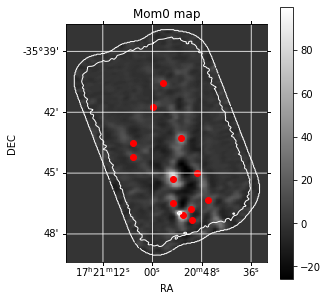

On mom0 map, red circles indicate LEAF,
            blue circles indicate rejected LEAF due to location at edges
#####################################
   no leaf: 1 , edge: 0
END: Section.7-4


In [35]:
hdu = fits.open(fits_name)[0]

remove_candidate=['NAXIS3','CTYPE3','CRVAL3','CDELT3','CRPIX3','CUNIT3','CUNIT3','CROTA3',
                  'PC1_3','PC2_3','PC3_1','PC3_2','PC3_3',]

for i in range(len(remove_candidate)):
    if remove_candidate[i] in hdu.header:
        hdu.header.remove(remove_candidate[i])

hdu.header['NAXIS'] = 2
wcs2   = WCS(hdu.header)
hdu    = fits.open(output_name)[2]
result = hdu.data
select_struct  = []

print(result.shape)
print(rms_map.shape)

edge_rms_thrd = 0.06 # Jy/beam (要確認)
levels = [edge_rms_thrd]
xcont = np.arange(np.size(mom0, axis=1))
ycont = np.arange(np.size(mom0, axis=0))

# color range of plotted mom0 image
intmin = np.nanmin(mom0)*0.9 if np.nanmin(mom0) < 0 else np.nanmin(mom0)*1.1
intmax = np.nanmax(mom0)*0.9
# plot mom0 map
plt.figure(figsize=(4.5,5))
plt.subplot(projection=wcs)
plt.contour(xcont, ycont, rms_map, colors='white', levels=levels, linewidths=1.0)
plt.imshow(mom0, vmin=intmin, vmax=intmax, origin='lower', interpolation='nearest', cmap=plt.cm.gray)
plt.grid(color='white', ls='solid')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title("Mom0 map")
clb = plt.colorbar()

crno = 0
nolef = 0
edgbp = 0

print("#####################################")
print("No, ID, positions[hmsdms], positions[pixels], velocity[pixel], peak, leaf or not")
for i in range(np.max(result)+1):
    leaf_check = ""
    parent_check = ""

    if len(d[i].children) == 0:
        leaf_check ="LEAF"
    ttt = str(d[i].parent)    
    if ttt == str("None") and len(d[i].children) != 0:
        parent_check ="trunk"

    RA_tmp, DEC_tmp = wcs2.all_pix2world([cat[i][10]], [cat[i][11]], 0)
    c = SkyCoord(ra=RA_tmp*u.degree, dec=DEC_tmp*u.degree)
    position_hmsdms = c.to_string('hmsdms')

    if leaf_check == "LEAF":
        if rms_map[int(round(cat[i][11],0)), int(round(cat[i][10],0))] < edge_rms_thrd:
            crno+=1
            select_struct.append(cat[i][0])
            print(crno, cat[i][0], position_hmsdms[0], \
                  int(round(cat[i][10],0)), int(round(cat[i][11],0)), \
                  int(round(cat[i][8],0)), \
                  data[int(round(cat[i][8],0)), int(round(cat[i][11],0)), int(round(cat[i][10],0))], \
                  leaf_check, parent_check)
            plt.scatter(int(cat[i][10]),int(cat[i][11]),marker="o",c="red")
        else:
            edgbp+=1
            plt.scatter(int(cat[i][10]),int(cat[i][11]),marker="o",c="blue")
    else:
        nolef+=1
#        leafでない構造の位置をプロットしたい場合、以下のコメントアウトを外す
#        plt.scatter(int(cat[i][10]),int(cat[i][11]),marker="o",c="green")

print("")
plt.show()

print("On mom0 map, red circles indicate LEAF,")
print("            blue circles indicate rejected LEAF due to location at edges")
print("#####################################")
print('   no leaf:', nolef, ', edge:', edgbp)
print("END: Section.7-4")

### 7-5. 速度方向の閾値の追加 及び ビリアル質量の見積もり

何をもって分子雲コアと言えるのかについては、明確な答えはありません。dendrogramは階層構造を同定しますが、ここではdendrogramで同定される最小の構造である「leaf」を分子雲コアの候補と仮定することにします。<br><br>
デフォルトのdendrogramにはない基準で、速度方向のselectionを行います。<br>
Section 7.1で、“min_npix”の閾値(min_npix_threshold\*ppb)を与えました。これは、構造の最小サイズの閾値ですが、キューブデータの場合、全てのチャンネルでのピクセル数となってしまいます。たとえば、min_npix=10と与えても、10 chで1 pixelずつ受かっていれば、その構造は同定されてしまいます。なので、ここでは、各チャンネルでのピクセル数を数え、各チャンネルで基準を満たすかを調べます。何チャンネル以上条件を満たせば良いかの判断は難しいですが、最低限 2,3 chennelは必要かと思います。
<ul>
  <li>velocity_channel_threshold = 3      # ch</li>
</ul>
leaf（コア候補）のサイズについて、空間サイズ(arcsec)から物理サイズ(pc)に変換するために、天体の距離が必要になります。観測データの天体に応じて適切に設定して下さい。デフォルトでは分子雲NGC6334を想定して1.75kpcとしています。
<ul>
  <li>distance                   = 1750.0 # pc</li>
</ul>
また、検出されたleaf（コア候補）のpixelを全て平均してスペクトルを作成し、ガウシアンフィットを行い、サイズとガウシアンフィットの結果から得られた速度幅の情報を使ってビリアル質量も求めています。
<br>
ガウシアンフィットについては、初期値を天体に合わせて調整する必要がありますが、<font color="red">フィットがうまく行かない場合があるので表示されるプロットの結果を見て判断して下さい。</font>
デフォルトでは、平均スペクトルからシステム速度(“Vsys_init”; コア候補の速度中心)としてピーク強度の速度を、速度幅(“dV_init”)として速度分散を算出して4.0km/sを上限として初期値として採用しています。それぞれ分子雲の典型的な値を指定する方法でも良いかもしれません。
ガウシアンフィットの結果は、各leafごとにスペクトルにして表示されます。
<br>
ビリアル質量については、uniform densityの球を仮定して以下の様に計算しています (Shimajiri et al. 2017)。
<small><small>$M_{\rm vir}$</small></small>がビリアル質量、<small><small>$Radius$</small></small>が半径、<small><small>$\Delta V$</small></small>が速度幅(FWHM)です。
<br>
$$M_{\rm vir}\,[{\rm M_{\odot}}]= 125 \; Radius\,[{\rm pc}] \; \Delta V\,[{\rm km\,s^{-1}}]^2$$
<br>
コア候補ごとの各パラメータは“core_list”という配列に一旦格納され、後でリストを表示します。
<font color="red">なお、ここの処理はデータによっては非常に時間がかかるので注意！</font>

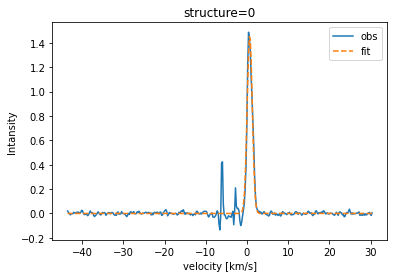

<Figure size 432x288 with 0 Axes>

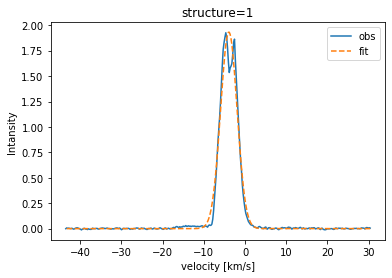

<Figure size 432x288 with 0 Axes>

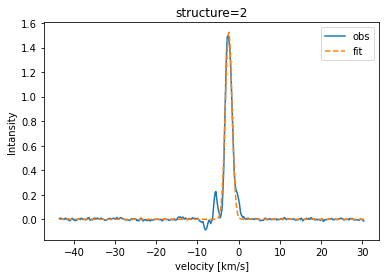

<Figure size 432x288 with 0 Axes>

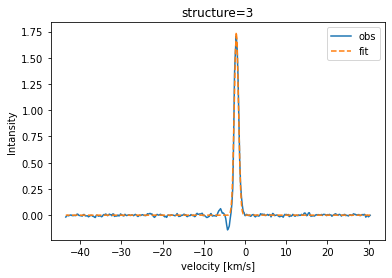

<Figure size 432x288 with 0 Axes>

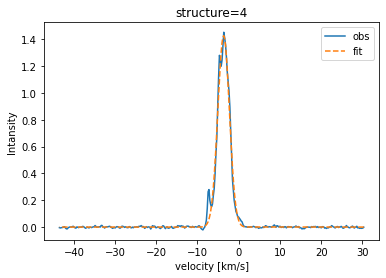

<Figure size 432x288 with 0 Axes>

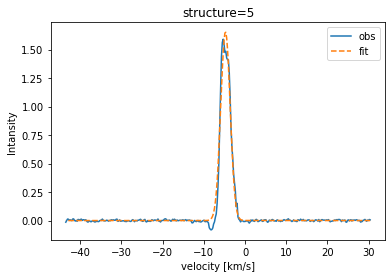

<Figure size 432x288 with 0 Axes>

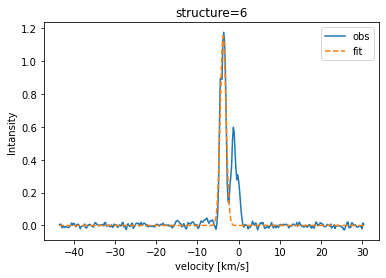

<Figure size 432x288 with 0 Axes>

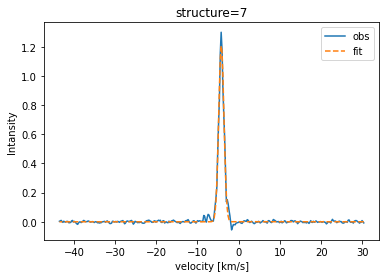

<Figure size 432x288 with 0 Axes>

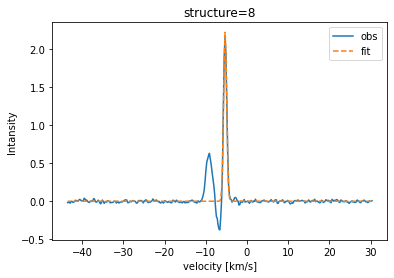

<Figure size 432x288 with 0 Axes>

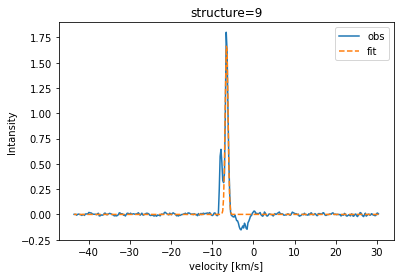

<Figure size 432x288 with 0 Axes>

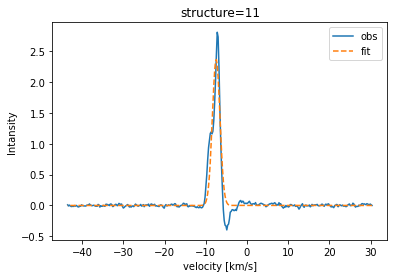

<Figure size 432x288 with 0 Axes>

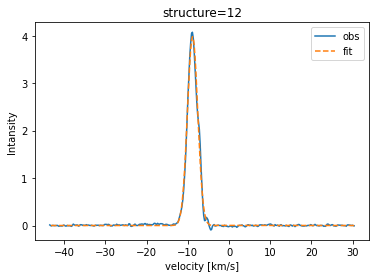

This section took  877.0887117385864  sec.
END: Section.7-5a


<Figure size 432x288 with 0 Axes>

In [36]:
start_time = time.time() 

#####################################
# Definition of function
#####################################
from scipy.optimize import curve_fit
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def nmoment(x, counts, c, n):
    return np.sum(counts*(x-c)**n)/np.sum(counts)

#####################################
# Check pixel numbers per channel for each structure. 
#####################################
hdu    = fits.open(output_name)[2]
result = hdu.data
count = np.zeros((np.max(result)+1, naxis3))
for j in range(naxis2):
    for k in range(naxis1):
        for velo in range(naxis3):
            value=result[velo,j,k] 
            if value >= 0:
                count[value,velo]=count[value,velo]+1

#####################################
# Estimate parameters for each structure. 
#####################################
velocity_channel_threshold = 3      # ch (要確認)
distance                   = 1750.0 # pc (要確認)
au2pc          = 206265.
good_structure = []
count_final    = 0
count_flagged  = 0
core_list      = []

for structure in select_struct:
    check = 0
    for i in range(naxis3):
        tmp=count[structure,i]
        if tmp >= min_npix_threshold*ppb:
            check = check + 1

    if check >= velocity_channel_threshold:
        count_final = count_final + 1
        good_structure.append(structure)
        Radius   = (cat[structure][2]/np.pi)**0.5 * distance / au2pc

        # Making averaged spectra over each pixel identified as a structure
        spectrum_tmp      = np.zeros(naxis3)
        veloc_pixel_count = 0
        int_tmp = 0.
        for j in range(naxis2):
            for k in range(naxis1):
                for i in range(naxis3):
                    value=result[i,j,k]
                    if value == structure:
                        veloc_pixel_count = veloc_pixel_count+ 1
                        spectrum_tmp = spectrum_tmp + np.array([data[velo,j,k] for velo in range(naxis3)])
                        if data[velo,j,k] >= int_tmp:
                            int_tmp = data[velo,j,k]

        spectrum_tmp = spectrum_tmp/veloc_pixel_count

        # Setting initial parameters for gaussian fitting
        Tpeak_init = np.nanmax(spectrum_tmp)
        spwtavg  = np.average(axis, weights=spectrum_tmp) # km/s
        mom2spc  = np.abs(nmoment(axis, spectrum_tmp, spwtavg, 2)) # km/s
        Vsys_init = axis[np.nanargmax(spectrum_tmp)] # km/s
        dV_init   = mom2spc if mom2spc < 4.0 else 4.0 # km/s        
#        Vsys_init = spwtavg # km/s
#        Vsys_init = -2.8 # km/s (必要ならコメントアウトを外して修正)
#        dV_init   =  8.0 # km/s (必要ならコメントアウトを外して修正)

        # Gaussian fitting
        popt,pcov = curve_fit(gauss_function, axis, spectrum_tmp, \
                              p0 = [Tpeak_init, Vsys_init, dV_init])
        dV        = popt[2]*2.35

        # Plotting spectra
        plt.figure()
        plt.xlabel("velocity [km/s]")
        plt.ylabel("Intansity")
        plt.title("structure="+str(structure))
        plt.plot(axis, spectrum_tmp, label="obs")
        plt.plot(axis, gauss_function(axis, *popt), "--", label='fit')
        plt.legend()
        plt.show()
        plt.clf()

        # Estimate virial mass
        Mvir = 125.*Radius*dV*dV
        # Transfer from pixel to coordinates
        RA_tmp, DEC_tmp = wcs2.all_pix2world([cat[structure][10]], [cat[structure][11]], 0)
        c               = SkyCoord(ra=RA_tmp*u.degree, dec=DEC_tmp*u.degree)
        position_hmsdms = c.to_string('hmsdms')

        core_pram = [count_final,
                     structure,
                     position_hmsdms[0],
                     Radius,
                     Tpeak_init, # popt[0],
                     popt[1],
                     dV,
                     Mvir]
        if count_final==1:
            core_list = core_pram
        else:
            core_list = np.vstack([core_list, core_pram])

    else:            
        count_flagged = count_flagged + 1

end_time = time.time() 
elapsed_time = end_time - start_time
print("This section took ", elapsed_time, " sec.")
print("END: Section.7-5a")

配列“core_list”に格納された、同定されたコア候補天体の各パラメータをリストにして表示します。<br>
また、csv形式でテキストファイルに出力します。ファイル名は以下で指定します。
<ul>
  <li>outcorefile = "ngc6334.dendrogram_core_list.csv"</li>
</ul>

In [37]:
print(core_list.shape)

print("#####################################")
print("# No, structure, positions, Radius_a[pc], Tpeak[K], Vsys[km/s], dV[km/s], Mvir[Msun]")
for pp in range(int(count_final)):
    Radius_a = str('%04.3f'%float(core_list[pp][3]))+" pc"
    tips_Tpeak= str('%04.3f'%float(core_list[pp][4]))+" Jy/bm"
    tips_Vsys = str('%03.2f'%float(core_list[pp][5]))+" km/s"
    tips_dV   = str('%04.3f'%float(core_list[pp][6]))+" km/s"
    Mvir2 = str('%03.2f'%float(core_list[pp][7]))+" Msun"
    print(core_list[pp][0], core_list[pp][1], core_list[pp][2], \
          Radius_a, tips_Tpeak, tips_Vsys, tips_dV, Mvir2)
print("#####################################")

outcorefile = "ngc6334.dendrogram_core_list.csv" # (要確認)
if(os.path.isfile(outcorefile) == True):
    os.remove(outcorefile)
with open(outcorefile, 'w') as f:
    writer = csv.writer(f)
    for pp in range(int(count_final)):
        writer.writerow(core_list[pp])

print("")
print("Before the velocity selection, ", count_flagged + count_final, " leafs(cores) were selected.")
print("After the velocity selection,  ", count_final, " leafs(cores) are selected.")
print("END: Section.7-5b")

(12, 8)
#####################################
# No, structure, positions, Radius_a[pc], Tpeak[K], Vsys[km/s], dV[km/s], Mvir[Msun]
1 0 17h20m57.21687113s -35d40m32.45894012s 0.123 pc 1.486 Jy/bm 0.68 km/s 1.460 km/s 32.74 Msun
2 1 17h20m54.86317894s -35d45m16.52443649s 0.279 pc 1.926 Jy/bm -3.93 km/s 4.703 km/s 771.52 Msun
3 2 17h20m46.34606718s -35d46m16.62207547s 0.251 pc 1.497 Jy/bm -2.42 km/s 1.912 km/s 114.80 Msun
4 3 17h21m04.6887297s -35d44m10.11402375s 0.157 pc 1.708 Jy/bm -2.10 km/s 1.208 km/s 28.55 Msun
5 4 17h20m52.93206237s -35d43m15.63127995s 0.271 pc 1.452 Jy/bm -3.65 km/s 3.313 km/s 371.20 Msun
6 5 17h20m54.98245384s -35d46m27.02889237s 0.187 pc 1.592 Jy/bm -4.76 km/s 2.681 km/s 167.98 Msun
7 6 17h20m48.93495911s -35d44m58.42187942s 0.137 pc 1.175 Jy/bm -3.77 km/s 1.636 km/s 45.81 Msun
8 7 17h21m04.44221091s -35d43m31.09398731s 0.229 pc 1.301 Jy/bm -4.21 km/s 1.483 km/s 62.82 Msun
9 8 17h20m50.2334437s -35d47m17.22033438s 0.132 pc 2.172 Jy/bm -5.29 km/s 0.881 km/s 12.77 

### 7-6. コア候補のパラメーターのプロット例

前節で同定されたleaf（コア候補）の各パラメータを使って、2つのパラメータ間の関係をグラフにする事が出来ます。
以下にプロットの参考例を表示します。<br>
プロットから除外したいleafがあれば、“flag”にstructure IDを記入するとそのleafを除いてプロットを作成します。

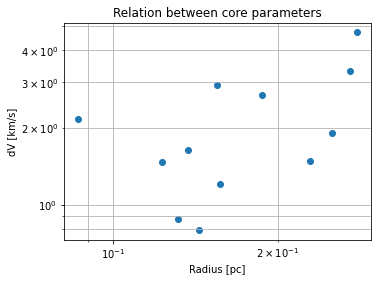

number of plotted core is 12
END: Section.7-6


In [38]:
flag = []
# flag = [109, 200, 217] (記入例)

xid = 3 # Radius [pc]
yid = 6 # dV [km/s]
#xid = 4 # Tpeak [Jy/bm]
#yid = 7 # Mvir [Mo]
plx = []
ply = []
chk = 0
for pp in range(int(count_final)):
    for ss in flag:
        if ss == int(core_list[pp][1]):
            chk = 1
            break
    if chk == 0:
        plx = np.append(plx, float(core_list[pp][xid]))
        ply = np.append(ply, float(core_list[pp][yid]))
    chk = 0
ply = np.abs(ply)

plt.figure(figsize=(5.5, 4))
plt.scatter(plx, ply)
plt.xscale('log')
plt.yscale('log')
plt.title("Relation between core parameters")
plt.xlabel("Radius [pc]") # x axis
plt.ylabel("dV [km/s]") # y axis
plt.grid(which="both")
plt.show()
print("number of plotted core is "+str(len(plx)))
print("END: Section.7-6")

以上、ALMAアーカイブデータをもとに、dendrogramを使ってleaf（コア候補）を検出する手順を紹介しました。
実際に同定したコア候補の各パラメータを使う場合は、適切に同定されているか慎重に確認して下さい。また、本当に分子雲コアとみなして良いかについては慎重に議論してください。

In [39]:
!ls -lh ngc6334.*

-rw-r--r-- 1 root root 116M Jan  5 02:23 ngc6334.cube.image.fits
-rw-r--r-- 1 root root 344K Jan  5 02:25 ngc6334.cube.image.mom0.fits
-rw-r--r-- 1 root root 681K Jan  5 02:24 ngc6334.cube.image.rms.fits
-rw-r--r-- 1 root root 232M Jan  5 02:25 ngc6334.cube.image.SN.fits
-rw-r--r-- 1 root root 1.7K Jan  5 02:39 ngc6334.dendrogram_core_list.csv
-rw-r--r-- 1 root root 232M Jan  5 02:25 ngc6334.dendrogram_result_ext1_map.fits
-rw-r--r-- 1 root root 116M Jan  5 02:25 ngc6334.dendrogram_result_ext2_id_number.fits
-rw-r--r-- 1 root root 348M Jan  5 02:25 ngc6334.dendrogram_result.fits


上記は、ここまでの処理で作成されたファイルのリストを示しています。

In [40]:
print("END")

END
